In [1]:
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import socket

In [2]:
gpus = tf.config.list_physical_devices('GPU')
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
if socket.gethostname() == 'pop-os':
    df = pd.read_csv('../data/merged_labeled_daily.csv')
else:
    df = pd.read_csv('./data/merged.csv')

In [5]:
df = df.drop(columns=df.columns[:2])
df['measure_date'] = pd.to_datetime(df['measure_date'])
df['year'] = df['measure_date'].dt.year
df['month'] = df['measure_date'].dt.month
df['day'] = df['measure_date'].dt.day
df['weekday'] = df['measure_date'].dt.weekday
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31)
df['day_cos'] = np.cos(2 * np.pi * df['day'] / 31)

In [ ]:
df.head()

In [26]:
num_train_stations = 15
stations = df['station_code'].unique()

train_val_end_index = df[df['station_code'] == stations[num_train_stations - 1]].index[-1] + 1

num_train_samples = int(0.8 * train_val_end_index)
num_val_samples = train_val_end_index - num_train_samples
num_test_samples = len(df) - train_val_end_index

print("Train length: %s" % num_train_samples)
print("Validation length: %s" % num_val_samples)
print("Test length: %s" % num_test_samples)

total = num_train_samples + num_val_samples + num_test_samples
print(total, len(df), total == len(df))

Train length: 101258
Validation length: 25315
Test length: 42749
169322 169322 True


In [27]:
def get_features_and_targets(df, num_train_samples=None, feature_cols=None, target_cols=None, scale=True, mean=None, std=None):
    if num_train_samples is None:
        num_train_samples = len(df)
        
    if feature_cols is None:
        feature_cols = ['HS', 'day_sin', 'day_cos', 'month_sin', 'month_cos']

    if target_cols is None:
        target_cols = ['no_snow']
        
    if (mean is None) ^ (std is None):
        raise Exception('mean and std must both be set or unset')

    feature_cols = df[feature_cols].values
    target_cols = df[target_cols].values
    
    if not scale:
        return feature_cols, target_cols, None, None
    
    if mean is None:
        mean = feature_cols[:num_train_samples].mean(axis=0)
        feature_cols -= mean
        std = feature_cols[:num_train_samples].std(axis=0)
        feature_cols /= std
    else:
        feature_cols = (feature_cols - mean) / std

    return feature_cols, target_cols, mean, std

In [28]:
features, targets, _, _ = get_features_and_targets(df, num_train_samples)

print(targets[:3])
print(features[:3])

[[False]
 [False]
 [False]]
[[-0.67526634  0.41693307 -1.33640095 -1.22524466  0.69065301]
 [-0.47970907  0.13909518 -1.39453858 -1.22524466  0.69065301]
 [-0.7061438  -0.14454893 -1.39453858 -1.22524466  0.69065301]]


In [ ]:
def sequence_debugging():
    int_sequence = np.arange(30)

    train_end_index = int(0.5 * len(int_sequence))
    val_end_index = int(0.75 * len(int_sequence))

    sequence_length = 3
    target_start_idx = sequence_length - 1

    train_dataset = keras.utils.timeseries_dataset_from_array(
        data=int_sequence,
        targets=int_sequence[target_start_idx:],
        sequence_length=sequence_length,
        start_index=0,
        end_index=train_end_index
    )

    val_dataset = keras.utils.timeseries_dataset_from_array(
        data=int_sequence,
        targets=int_sequence[target_start_idx:],
        sequence_length=sequence_length,
        start_index=train_end_index,
        end_index=val_end_index
    )

    test_dataset = keras.utils.timeseries_dataset_from_array(
        data=int_sequence,
        targets=int_sequence[target_start_idx:],
        sequence_length=sequence_length,
        start_index=val_end_index
    )

    print("Train:")
    for inputs, targets in train_dataset:
        for i in range(inputs.shape[0]):
            print([int(x) for x in inputs[i]], int(targets[i]))

            
    print("\nVal:")
    for inputs, targets in val_dataset:
        for i in range(inputs.shape[0]):
            print([int(x) for x in inputs[i]], int(targets[i]))

    print("\nTest:")
    for inputs, targets in test_dataset:
        for i in range(inputs.shape[0]):
            print([int(x) for x in inputs[i]], int(targets[i]))

In [29]:
import numpy as np
from tensorflow import keras

def create_dataset(features, targets, start_index=0, end_index=None, sequence_length=30, batch_size=128, shuffle=False):
    target_start_idx = sequence_length - 1
    
    return keras.utils.timeseries_dataset_from_array(
        data=features,
        targets=targets[target_start_idx:],
        sequence_length=sequence_length,
        sequence_stride=1,
        sampling_rate=1,
        batch_size=batch_size,
        shuffle=shuffle,
        start_index=start_index,
        end_index=end_index
    )

train_dataset = create_dataset(features, targets, start_index=0, end_index=num_train_samples, shuffle=True)
val_dataset = create_dataset(features, targets, start_index=num_train_samples, end_index=num_train_samples + num_val_samples, shuffle=True)
test_dataset = create_dataset(features, targets, start_index=num_train_samples + num_val_samples, end_index=(len(df) - 1), shuffle=False)

In [8]:
import re

class MonteCarloDropout(keras.layers.Dropout):
    def call(self, inputs, training=None):
        return super().call(inputs, training=True)
    
def create_network(architecture, input_shape, dropout_rate=0.5, summary=True):
    arch_split = architecture.split('-')
    dense = True
    bidirectional = False
    layers = []

    digits_pattern = re.compile(r"\d+")
    
    if 'l' in arch_split[0]:
        rnn_layer = 'LSTM'
    elif 'g' in arch_split[0]:
        rnn_layer = 'GRU'
    else:
        raise Exception('rnn_layers must be one of [LSTM, GRU]')

    if 'b' in arch_split[0]:
        bidirectional = True
        
    for i, layer in enumerate(reversed(arch_split)):
        no_units = int(digits_pattern.findall(layer)[0])

        if dense:
            activation = 'sigmoid' if i == 0 else 'relu'
            layers.append(keras.layers.Dense(no_units, activation=activation))
        else:
            args = {
                'units': no_units,
            }

            if '(d)' not in arch_split[-i]:
                args['return_sequences'] = True

            if i == len(arch_split) - 1:
                args['input_shape'] = input_shape
                
            current_layer = keras.layers.LSTM(**args) if rnn_layer == 'LSTM' else keras.layers.GRU(**args)
            
            if bidirectional:
                current_layer = keras.layers.Bidirectional(current_layer)
            
            layers.extend([
                MonteCarloDropout(dropout_rate),
                current_layer
            ])
            
        if '(d)' in layer:
            dense = False
            
    layers.reverse()
    
    if summary:
        for layer in layers:
            layer_type = str(type(layer))

            if 'Dense' in str(type(layer)):
                print(type(layer), layer.units, layer.activation)
            elif 'Bidirectional' in str(type(layer)):
                print(type(layer), layer.layer, layer.layer.units, layer.layer.activation, layer.layer.return_sequences)
            elif 'LSTM' in str(type(layer)):
                print(type(layer), layer.units, layer.activation, layer.return_sequences)
            elif 'GRU' in str(type(layer)):
                print(type(layer), layer.units, layer.activation, layer.return_sequences)
            elif 'Dropout' in layer_type:
                print(type(layer), layer.rate)

    return layers

# arch = "128(gb)-64-8(d)-1"
# input_shape = (sequence_length, features.shape[-1])
# network = create_network(arch, input_shape)


In [ ]:
arch = "128(l)-64-8(d)-1"
sequence_length = 30
input_shape = (sequence_length, features.shape[-1])
epochs = 10
model_batch_size = 64
checkpoint_name = 'snow_height_anomaly_multi_vars_gru.keras'
current_time = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
model_name = f"{current_time}_arch-{arch}_epochs-{epochs}_batch-{model_batch_size}_seq-{sequence_length}_num-train-stations-{num_train_stations}"
log_dir = f"./logs/{model_name}"

network = create_network(arch, input_shape)
model = keras.Sequential(network)
model.compile(
    optimizer='adam',
    metrics='accuracy',
    loss='binary_crossentropy'
)

history = model.fit(
    train_dataset,
    epochs=epochs,
    batch_size=model_batch_size,
    validation_data=val_dataset,
    # callbacks=[
        # keras.callbacks.ModelCheckpoint(checkpoint_name, save_best_only=True),
        # keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1) 
    # ]
)

In [30]:
def plot_keras_history(history):
    # Plot training & validation loss values
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

# plot_keras_history(history)

In [31]:
model.evaluate(test_dataset)

334/334 [==============================] - 7s 20ms/step - loss: 0.2880 - accuracy: 0.9352


[0.28800034523010254, 0.9351576566696167]

In [32]:
def plot_data(dfs, y='HS', target='no_snow', predictions=None):
    if not isinstance(dfs, list):
        dfs = [dfs]

    if not isinstance(predictions, list):
        predictions = [predictions] if predictions else []

    if not isinstance(y, list):
        y = [y] * len(dfs)

    if not isinstance(target, list):
        target = [target] * len(dfs)

    if len(predictions):
        rows = len(dfs) * 2
    else:
        rows = len(dfs)

    fig, axes = plt.subplots(rows, 1, figsize=(20, 5 * rows))

    if not isinstance(axes, np.ndarray):
        axes = [axes]

    for i, df in enumerate(dfs):
        plot_df = df.copy()
        plot_df.index = pd.to_datetime(plot_df['measure_date'])
        station_code = plot_df['station_code'].iloc[0]

        # Plot original data
        ax = axes[2 * i] if len(predictions) else axes[i]
        ax.set_xlabel('Date')
        ax.set_ylabel(y[i])
        ax.set_title(f'Station: {station_code} | Original Data with Anomalies Highlighted')
        ax.plot(plot_df.index, plot_df[y[i]], label='Data', marker='o', linestyle='-', ms=4)
        ax.scatter(plot_df[plot_df[target[i]]].index, plot_df[plot_df[target[i]]][y[i]], color='red', label='Anomalies', zorder=5, s=20)
        ax.legend()

        # Plot predictions
        if len(predictions):
            ax = axes[2 * i + 1]
            ax.set_xlabel('Date')
            ax.set_ylabel(y[i])
            ax.set_title(f'Station: {station_code} | Predicted Data with Anomalies Highlighted')
            ax.plot(plot_df.index, plot_df[y[i]], label='Data', marker='o', linestyle='-', ms=4)
            ax.scatter(plot_df[predictions[i]].index, plot_df[predictions[i]][y[i]], color='green', label='Predicted Anomalies', zorder=5, s=20)
            ax.legend()

    plt.tight_layout()
    plt.show()

87/87 [==============================] - 1s 16ms/step


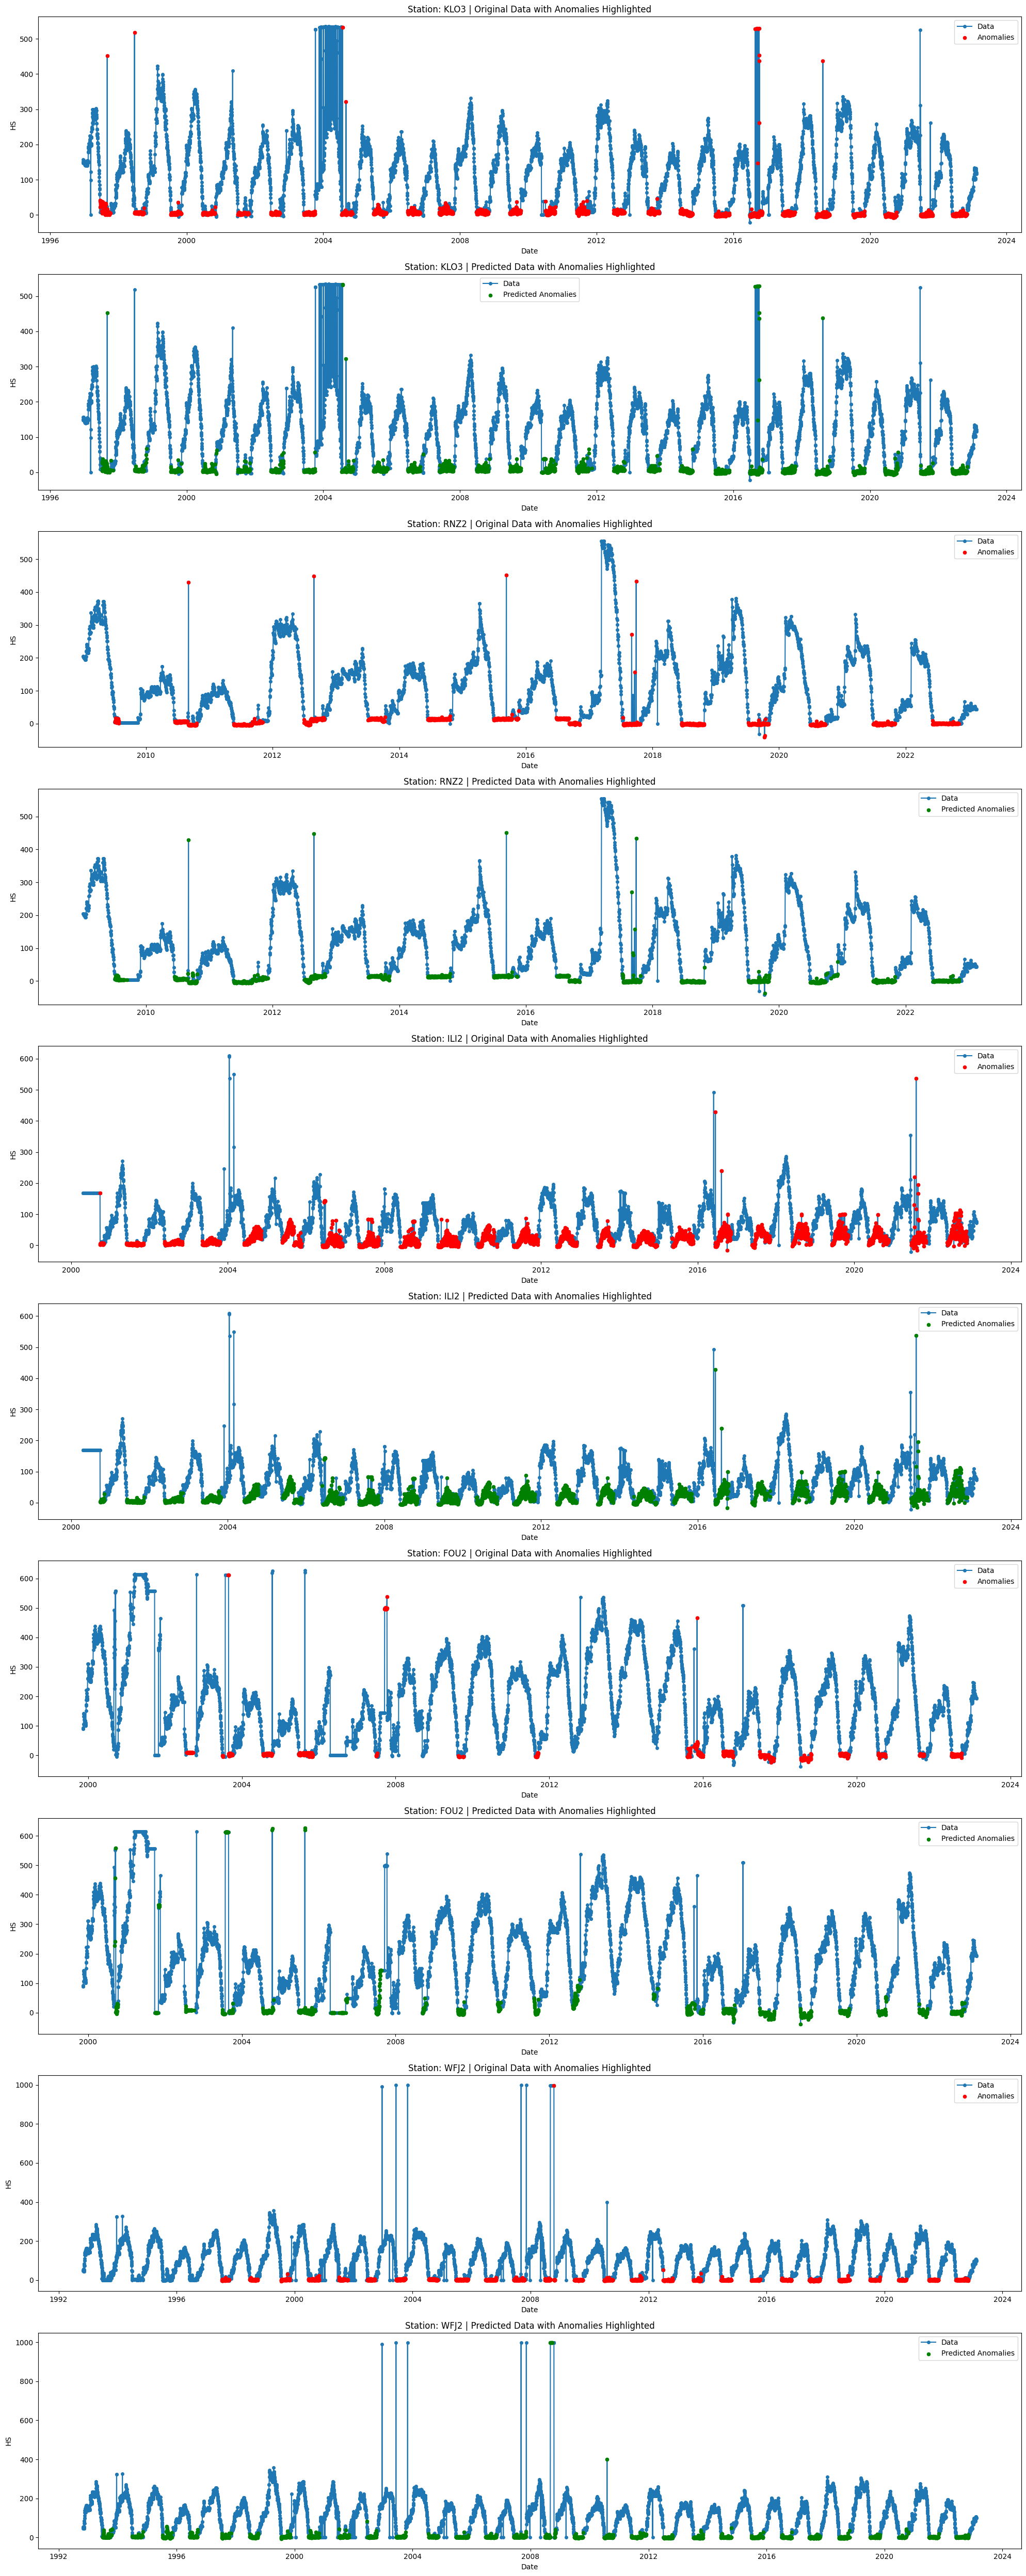

In [33]:
test_stations = df[train_val_end_index:]['station_code'].unique()
test_stations = [(df[df['station_code'] == station].index.values[[0, -1]], df[df['station_code'] == station][sequence_length:]) for station in test_stations]

predictions = [model.predict(create_dataset(features, targets, station[0][0], station[0][1])).reshape((-1,)) > 0.5 for station in test_stations]

plot_data(
    [station[1] for station in test_stations],
    predictions=predictions
)

In [12]:
def predict_with_uncertainty(model, x, n_iter=100):
    preds = np.array([model.predict(x, verbose=0) for _ in range(n_iter)])
    uncertainty = np.std(preds, axis=0)
    scaled_uncertainty = (uncertainty - uncertainty.min()) / (uncertainty.max() - uncertainty.min())
    return scaled_uncertainty.mean()

# uncertainties = [predict_with_uncertainty(model, create_dataset(station[0][0], station[0][1]), n_iter=20) for station in test_stations]
# accuracy = [model.evaluate(create_dataset(station[0][0], station[0][1]))[1] for station in test_stations]
# 
# print(np.corrcoef(uncertainties, accuracy))

In [19]:
# arch = "128(l)-64-8(d)-15
arch = "128(l)-64-8(d)-1"
sequence_length = 30 # TODO: Make sequence length global
input_shape = (sequence_length, 5) # TODO: Replace with variable that contains number of features
epochs = 10
model_batch_size = 64

network = create_network(arch, input_shape)

model = keras.Sequential(network)
model.compile(
    optimizer='adam',
    metrics='accuracy',
    loss='binary_crossentropy'
)

group_split_num = 15
last_training_station = df['station_code'].unique()[:group_split_num]
active_learning_samples_index = df[df['station_code'] == last_training_station[-1]].index[-1] + 1

active_learning_df = df[:active_learning_samples_index]
out_of_sample_df = df[active_learning_samples_index:]

active_stations = np.random.choice(active_learning_df['station_code'].unique(), 1).tolist()
split_percentage = 0.8
summary = []

for i in range(group_split_num):
    print(f'====================================================')
    print(f'Active Learning Iteration #{i}')
    print(f'Current Training Stations: {active_stations}')
    current_iteration_train_df, current_iteration_val_df = pd.DataFrame(), pd.DataFrame()

    for station in active_stations:
        station_data = df[df['station_code'] == station]
        split_index = int(len(station_data) * split_percentage)

        current_iteration_train_df = pd.concat([current_iteration_train_df, station_data[:split_index]])
        current_iteration_val_df = pd.concat([current_iteration_val_df, station_data[split_index:]])

    current_iteration_df = pd.concat([current_iteration_train_df, current_iteration_val_df])
    split_index = len(current_iteration_train_df)
    
    print(f'Training samples: {len(current_iteration_train_df)}')
    print(f'Validation samples: {len(current_iteration_val_df)}')
    
    current_iteration_features, current_iteration_targets, current_iteration_mean, current_iteration_std = get_features_and_targets(current_iteration_df, split_index)
    
    current_iteration_train_dataset = create_dataset(current_iteration_features, current_iteration_targets, end_index=split_index, shuffle=True)
    current_iteration_val_dataset = create_dataset(current_iteration_features, current_iteration_targets, start_index=split_index, shuffle=True)
    
    history = model.fit(current_iteration_train_dataset, epochs=epochs, batch_size=model_batch_size, validation_data=current_iteration_val_dataset)

    out_of_sample_features, out_of_sample_targets, _, _ = get_features_and_targets(out_of_sample_df, mean=current_iteration_mean, std=current_iteration_std)
    out_of_sample_dataset = create_dataset(out_of_sample_features, out_of_sample_targets, shuffle=True)

    print(f'Evaluation model on out of sample data...')
    evaluation_results = model.evaluate(out_of_sample_dataset)

    inactive_stations_grouped = active_learning_df[~active_learning_df['station_code'].isin(active_stations)].groupby('station_code')
    uncertainties = {}
    most_uncertain_station_name = None
    
    if inactive_stations_grouped.ngroups != 0:
        print(f'Calculating uncertainty scores...')
        for name, group in inactive_stations_grouped:
            inactive_station_df = group.reset_index(drop=True)
            inactive_station_features, inactive_station_targets, _, _ = get_features_and_targets(inactive_station_df, scale=False)
            inactive_station_dataset = create_dataset(inactive_station_features, inactive_station_targets, shuffle=True)
            uncertainty_score = predict_with_uncertainty(model, inactive_station_dataset, n_iter=5)
            uncertainties[name] = uncertainty_score

        most_uncertain_station_name = max(uncertainties, key=uncertainties.get)

        print(f'Most uncertain {most_uncertain_station_name}')

    summary.append({
        'iteration': i,
        'active_learning_train': active_stations.copy(),
        'active_learning_predict': uncertainties.keys(),
        'evaluation_results': evaluation_results,
        'uncertainty_scores': uncertainties,
        'most_uncertain': most_uncertain_station_name
    })

    active_stations.append(most_uncertain_station_name)

<class 'keras.layers.rnn.lstm.LSTM'> 128 <function tanh at 0x7f9a3302d040> True
<class '__main__.MonteCarloDropout'> 0.5
<class 'keras.layers.rnn.lstm.LSTM'> 64 <function tanh at 0x7f9a3302d040> False
<class '__main__.MonteCarloDropout'> 0.5
<class 'keras.layers.core.dense.Dense'> 8 <function relu at 0x7f9a33029ca0>
<class 'keras.layers.core.dense.Dense'> 1 <function sigmoid at 0x7f9a3302d1f0>
Active Learning Iteration #0
Current Training Stations: ['AMD2']
Epoch 1/10
58/58 [==============================] - 7s 46ms/step - loss: 0.2352 - accuracy: 0.9150 - val_loss: 0.1331 - val_accuracy: 0.9479
Epoch 2/10
58/58 [==============================] - 2s 27ms/step - loss: 0.1621 - accuracy: 0.9296 - val_loss: 0.1250 - val_accuracy: 0.9457
Epoch 3/10
58/58 [==============================] - 2s 33ms/step - loss: 0.1532 - accuracy: 0.9315 - val_loss: 0.1318 - val_accuracy: 0.9319
Epoch 4/10
58/58 [==============================] - 2s 29ms/step - loss: 0.1466 - accuracy: 0.9323 - val_loss: 0.11

In [20]:
summary = pd.DataFrame(summary)
summary

,iteration,active_learning_train,active_learning_predict,evaluation_results,uncertainty_scores,most_uncertain
0,0,[AMD2],"(ARO3, BOR2, FLU2, FNH2, GLA2, GUT2, KLO2, LAG...","[0.28082573413848877, 0.9121488928794861]","{'ARO3': 0.11018798, 'BOR2': 0.004916646, 'FLU...",FLU2
1,1,"[AMD2, FLU2]","(ARO3, BOR2, FNH2, GLA2, GUT2, KLO2, LAG3, SHE...","[0.27283939719200134, 0.9169943928718567]","{'ARO3': 0.3407839, 'BOR2': 0.30149218, 'FNH2'...",SHE2
2,2,"[AMD2, FLU2, SHE2]","(ARO3, BOR2, FNH2, GLA2, GUT2, KLO2, LAG3, SLF...","[0.25275057554244995, 0.9242509603500366]","{'ARO3': 0.41040796, 'BOR2': 0.4169323, 'FNH2'...",GUT2
3,3,"[AMD2, FLU2, SHE2, GUT2]","(ARO3, BOR2, FNH2, GLA2, KLO2, LAG3, SLF2, SPN...","[0.2503879964351654, 0.9054073095321655]","{'ARO3': 0.5501397, 'BOR2': 0.46590984, 'FNH2'...",ARO3
4,4,"[AMD2, FLU2, SHE2, GUT2, ARO3]","(BOR2, FNH2, GLA2, KLO2, LAG3, SLF2, SPN2, STN...","[0.25987204909324646, 0.914068341255188]","{'BOR2': 0.5974509, 'FNH2': 0.39873096, 'GLA2'...",BOR2
5,5,"[AMD2, FLU2, SHE2, GUT2, ARO3, BOR2]","(FNH2, GLA2, KLO2, LAG3, SLF2, SPN2, STN2, TRU...","[0.24178752303123474, 0.9254213571548462]","{'FNH2': 0.4364455, 'GLA2': 0.44914964, 'KLO2'...",TUM2
6,6,"[AMD2, FLU2, SHE2, GUT2, ARO3, BOR2, TUM2]","(FNH2, GLA2, KLO2, LAG3, SLF2, SPN2, STN2, TRU2)","[0.24985019862651825, 0.9280664920806885]","{'FNH2': 0.43804374, 'GLA2': 0.44044307, 'KLO2...",SPN2
7,7,"[AMD2, FLU2, SHE2, GUT2, ARO3, BOR2, TUM2, SPN2]","(FNH2, GLA2, KLO2, LAG3, SLF2, STN2, TRU2)","[0.2729203701019287, 0.9275749325752258]","{'FNH2': 0.56565034, 'GLA2': 0.51399, 'KLO2': ...",FNH2
8,8,"[AMD2, FLU2, SHE2, GUT2, ARO3, BOR2, TUM2, SPN...","(GLA2, KLO2, LAG3, SLF2, STN2, TRU2)","[0.2737712562084198, 0.9303604960441589]","{'GLA2': 0.4401654, 'KLO2': 0.44279513, 'LAG3'...",SLF2
9,9,"[AMD2, FLU2, SHE2, GUT2, ARO3, BOR2, TUM2, SPN...","(GLA2, KLO2, LAG3, STN2, TRU2)","[0.3208243250846863, 0.9254915714263916]","{'GLA2': 0.43723786, 'KLO2': 0.4470492, 'LAG3'...",LAG3


In [22]:
! mkdir '2023-11-02_12-00-00_active_learning_results'
# save results to txt
summary.to_csv('./2023-11-02_12-00-00_active_learning_results/summary.csv', index=False)
# save output to txt

In [23]:
model.save('./2023-11-02_12-00-00_active_learning_results/model.keras')

In [24]:
! cat 2023-11-02_12-00-00_active_learning_results/output.txt

<class 'keras.layers.rnn.lstm.LSTM'> 128 <function tanh at 0x7f9a3302d040> True
<class '__main__.MonteCarloDropout'> 0.5
<class 'keras.layers.rnn.lstm.LSTM'> 64 <function tanh at 0x7f9a3302d040> False
<class '__main__.MonteCarloDropout'> 0.5
<class 'keras.layers.core.dense.Dense'> 8 <function relu at 0x7f9a33029ca0>
<class 'keras.layers.core.dense.Dense'> 1 <function sigmoid at 0x7f9a3302d1f0>
Active Learning Iteration #0
Current Training Stations: ['AMD2']
Epoch 1/10
58/58 [==============================] - 7s 46ms/step - loss: 0.2352 - accuracy: 0.9150 - val_loss: 0.1331 - val_accuracy: 0.9479
Epoch 2/10
58/58 [==============================] - 2s 27ms/step - loss: 0.1621 - accuracy: 0.9296 - val_loss: 0.1250 - val_accuracy: 0.9457
Epoch 3/10
58/58 [==============================] - 2s 33ms/step - loss: 0.1532 - accuracy: 0.9315 - val_loss: 0.1318 - val_accuracy: 0.9319
Epoch 4/10
58/58 [==============================] - 2s 29ms/step - loss: 0.1466 - accuracy: 0.9323 - val_loss: 0.11

In [25]:
! zip -r results.zip 2023-11-02_12-00-00_active_learning_results

  adding: 2023-11-02_12-00-00_active_learning_results/ (stored 0%)
  adding: 2023-11-02_12-00-00_active_learning_results/summary.csv (deflated 72%)
  adding: 2023-11-02_12-00-00_active_learning_results/output.txt (deflated 88%)
  adding: 2023-11-02_12-00-00_active_learning_results/model.keras (deflated 10%)
  adding: 2023-11-02_12-00-00_active_learning_results/.ipynb_checkpoints/ (stored 0%)
  adding: 2023-11-02_12-00-00_active_learning_results/.ipynb_checkpoints/output-checkpoint.txt (stored 0%)
